#Cellular Automata S.I.R. Model

##Description
Based on the reference paper, the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

##Assignments


1.   Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model.
2.   Repeat point 1 several times in order to obtain several reference datasets
3.   Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of
4.   Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

## Group Members


1.   Alberto Muraro - alberto.muraro.2@studenti.unipd.it
2.   Matteo Moro - matteo.moro.3@studenti.unipd.it
3.   Alberto Zancanaro - albi25.zanca@gmail.com (alberto.zancanaro.1@studenti.unipd.it)
4.   Andrea Michielon - andrea.michielon97@gmail.com








##Libraries Used

In [2]:
import numpy as np

import scipy as sc
from scipy.integrate import odeint

import networkx as nx
import math
import random

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.image as mgimg
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h1>The SIR model</h1>

Epidemic models are a really useful tool in the prediction and prevention of infectous diseases. There are several models in the literature, but we will focus on the SIR model.
One of the simplest model for an infectous disease is considering a single pathogen carried by individuals where the people who contract this pathogen are able to infect others. We also make the assumption that we have N people in a isolated system (for example people on the same island or state with closed borders). 

We now divide the population three different categories:
* Susceptible [**S**]: people that have yet to contract the disease and do not have the immunity
* Infected [**I**]: people that have the disease and are able to spread it
* Recovered [**R**]: people that have recovered from the disease and they are immune to it. Note that also people that are dead are included in this category since they cannot spread the virus anymore.

We define S, I and R as the number of people in each category, in this way
$$
S+I+R=N
$$
and we also define s=S/N, i=I/N and r=R/N as the percentage of the population in each category, in this way we have that:
$$
s+i+r=1
$$

We also make the assumption of memoryless recovery, in this way we have that the time that an individual spends being sick is exponentially distribuited with parameter $\gamma$. This means that :
$$
\mathbb{E}[\text{Time spent being sick}]= \frac{1}{\gamma}
$$

We can now wrote the following equations for the SIR model:
\begin{align} 
\frac{\partial s}{\partial t} &= -\lambda i s\\
\frac{\partial i}{\partial t} &= \lambda i s - \gamma i \\
\frac{\partial r}{\partial t} &= \gamma i
\end{align}

Another important parameter is the basic reproductive ratio $R_0$ (which due to covid19 almost every italian has heard about it) which is simply defined as:
$$
R_0 = \frac{\lambda}{\gamma}
$$
And can be viewed as:
$$
R_0 = \mathbb{E}[\text{#secondary infections
caused by an infected individual at time 0]}
$$

Since there are no closed form solution for the differential equation of the SIR model, we will give a numerical solution, using scipy, in order to better comprehend the importance that $R_0$ has.

In [3]:
#Define the three differential equation
def partial_derivatives(initial_condition, t, my_lambda, gamma):
    s, i, r = initial_condition

    # Susceptible Update Equation
    ds = -my_lambda * i * s

    #  Infected Update Equation
    di = my_lambda * i * s - gamma * i

    # Recovered Update Equation
    dr = gamma * i

    return ds, di, dr


#Use odeint to get a numerical solution and plot the results
def solve_eq(S0, I0, R0, my_lambda, gamma, days):

    R_0 = my_lambda/gamma
    N = S0+I0+R0

    s0 = S0/N
    i0 = I0/N
    r0 = R0/N
    t = np.linspace(0, days, days)
    initial_condition = s0, i0, r0


    s_plot, i_plot, r_plot = odeint(partial_derivatives, initial_condition, t, args = (my_lambda, gamma)).T
    print('{0:.2f}% of the total population contracted the virus'.format(s_plot[days-1]*100))
    plt.figure(figsize=(10,7))

    plt.plot(t, s_plot, label = 'Susceptible',linewidth = 3, c = '#0000FF')
    plt.plot(t, i_plot, label = 'Infected',linewidth = 3, c = '#FF4500')
    plt.plot(t, r_plot, label = 'Recovered',linewidth = 3, c = '#00a14e')
    plt.grid()
    plt.title('N = {}, R0 = {}'.format(N, R_0))
    plt.xlabel('Time [Days]')
    plt.ylabel('Fraction of individuals')
    plt.legend()
    plt.show()

15.62% of the total population contracted the virus


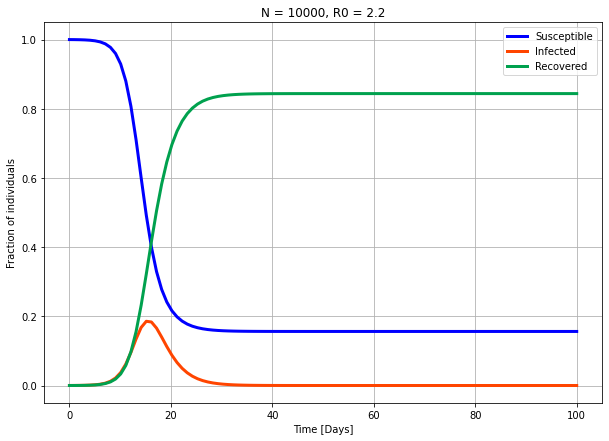

62.83% of the total population contracted the virus


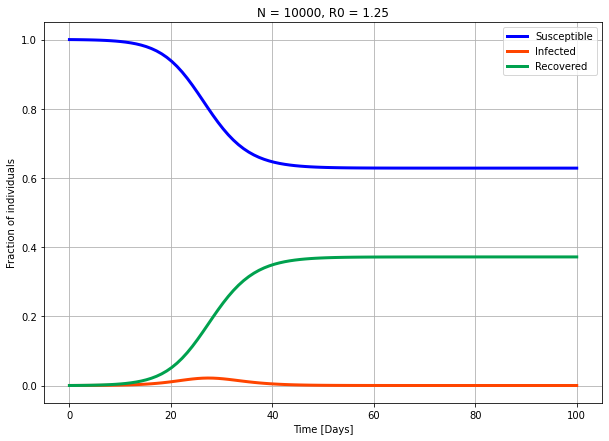

In [ ]:
solve_eq(9999, 1, 0, 1.1, 0.5, 100)
solve_eq(9999, 1, 0, 1.25, 1, 100)

As we can see when we $R_0$ of 1.25 in the long run only 15% of the population got infected, while with an $R_0$ of 2.2 over 60% of the population contracted the virus. Note that the the estimation of $R_0$ for covid19 is in the range 1,4÷3,8 (see https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/id/5268851), this is why it's important to try to lower this paramater by applying different measure. In this case we will use the notation $R_t$, which simply $R_0$ where some form of prevention is applied.

One thing that is missing from the model is the birth of new individuals and the death unrelated to the virus which can happen in any of the three different categories. We make the assumption that the birth rate and death rate are the same, so that our system is at a steady-state and the "natural" lifespan is exponetially distributed.

We call this birth/death rate $\mu$. Therefore:
$$
\mathbb{E}[\text{Natural lifespan}] = \frac{1}{\mu}
$$ 

We can now update the three previous differential equations: 
\begin{align} 
\frac{\partial s}{\partial t} &= \mu-\lambda i s -\mu s\\
\frac{\partial i}{\partial t} &= \lambda i s - \gamma i -\mu i \\
\frac{\partial r}{\partial t} &= \gamma i - \mu r
\end{align}
And $R_0$ becomes:
$$
R_0 = \frac{\lambda}{\gamma+\mu}
$$

As we can see the the birth rate is only present in the susceptible class, meaning that no new born has the virus or the immunity innately. The natural death is instead proportional to the percentage of the population for each class (recall that $s+i+r=1$)





# Cellular automata</h1>

In our implentation we cosidered a slighly different approach. We take a square or hexagonal grid where each cell state is determined by two different parameters: $\pi_{i,j}$ and $u_{i,j}$.
The first one is simply in which state (recovered, infected or susceptible) the cell currently is, while the latter takes in account the neighbors state which will determine the future states.

Another important concept that we introduce is the fact that an infected individual goes through three different sub-phases: incubation, infection and latency.
We define the times that an individual spends in each sub-phase as


*   $t_i$ for the incubation time
*   $t_p$ for the proper infection time
*   $t_l$ for the latency time

Each state $\pi_{i,j}$ is a value an integer value between -1 and $t_i+t_p+t_l$, where

*   -1 is assigned to the recovered individual
*    0 is the susceptible
*    greater or equal to 1 is instead reserved for the infected


In this way we can define the future state of a cell based on the immediatly previous state and on the states of the neighbors $u_{i,j}$, defined in the following equation:

$$
\pi_{i j}(t+1)=\left\{\begin{array}{ll}
\pi_{i j}(t)+1 & \text { if } 0<\pi_{i j}(t)<t_{i}+t_{p}+t_{l} \\
-1 & \text { if } \pi_{i j}(t) \geqslant t_{i}+t_{p}+t_{l} \\
0 & \text { if } \pi_{i j}(t)=0 \text { and } u_{i j}(t+1)<h \\
1 & \text { if } \pi_{i j}(t)=0 \text { and } u_{i j}(t+1) \geqslant h
\end{array}\right.
$$


Where h is a random number between [0,1] with probability density function p(h).

The update equation for $u_{i,j}$ is instead:
$$
u_{i j}(t+1)=\frac{1}{N}\left(\sum_{f n} I_{i j}(t) e^{-1}+\sum_{s n} I_{i j}(t) e^{-2}+\sum_{t c} I_{i j}(t) e^{-3}+\cdots\right)
$$
The first sum in over the first neighbors (as in the closest), the second sum over the second neighbors and so on. The number of sums that is considered is determined by the interaction radius, so if we choose an interaction radius of 1 only the immediate 4 neighbors (in the case of a square lattice) will be affected by the current state of the cell.

$N$ is a normalization constant which also is affected by the interaction radius and is defined as:
$$
N = \frac{1}{4*(e^{-1}+e^{-2}+e^{-3}+\cdots)}
$$

And the field $I_{i,j}$ is defined as

$$
I_{i j}(t+1)=\left\{\begin{array}{ll}
F\left(\pi_{i j}(t)\right) & \text { if } \pi_{i j}(t) \geqslant 1 \\
0 & \text { if } \pi_{i j}(t) \leqslant 0
\end{array}\right.
$$



Where $F(x)$ is a positive real function:
$$
F(x): (0,t_{i}+t_{p}+t_{l}) \rightarrow \mathbb{R}^+
$$
In other words F(x) assign to an individual the infectiouness as a function of its state $\pi_{i,j}$.
An example of F (which is the default implementation in our code with $f$ = 0.5) could be simply:

$$
F\left(\pi_{i j}(t)\right) =\left\{\begin{array}{ll}
f & \text { if } \pi_{i j}(t) > 0 \\
0 & \text { if } \pi_{i j}(t) =\ 0
\end{array}\right.
$$

Or if we want to take in consideration the fact that an indivual has a different infectiouness during the incubation, infection and latency time we could use something like:

$$
F\left(\pi_{i j}(t)\right) =\left\{\begin{array}{ll}
f_i & \text { if } 0 < \pi_{i j}(t) \leqslant t_i \\
f_p & \text { if } \pi_{i j}(t) \leqslant t_i+t_p \\
f_l & \text { if } \pi_{i j}(t) \leqslant t_i+t_p+t_l 
\end{array}\right.
$$

All of the above equations are implemented in the following class, which will be used for all the simulations.

# Implementation

In [4]:
class gridV1:

    def __init__(self, shape = (5,5), grid_type = "hex", ti = 1, tp = 1, tl = 1, f = 0.5, h = None, print_var = False, track_update = True):
        """
        Parameters
        ----------
        shape : Tuple, optional
            Shape of the grid The default is (5,5).
        grid_type : String, optional
            If hex we will use a grid with hexagon. Otherwise we will use a square grid. The default is "hex".
        ti : int, optional
            Incubation time. The default is 1.
        tp : int, optional
            Proper infection time. The default is 1.
        tl : int, optional
            Latecy time. The default is 1.
        f : float, optional
            Infectiouness of an individual. It's the value of F(t) function. The default is 0.5.
        h : float, optional
            The threshold for infection. If it's set to None or is minor of 0 or major of 1 it will randomly choesen between 0 and 1- The default is None.
        print_var : bool, optional
            Debug variable used during the creation of the class. If set to True the code will print the various step of execution. The default is False.
        track_update : bool, optional
            If set to True the class will save all the evolution of the population. The default is True.
        """

        self.print_var = print_var
        if(self.print_var): print("CREATION - START")
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # "Network" creation
        if(self.print_var): print("    GRID CREATION - START")
        

        if(isinstance(shape, tuple)): self.shape = shape
        else: self.shape = (20, 20)
        
        if(grid_type == "hex"): #Hexagonal lattice
            self.G = nx.generators.lattice.triangular_lattice_graph(shape[0], shape[1])
            self.l_type = 0
        else: #Square lattice
            self.G = nx.generators.lattice.grid_graph([shape[0], shape[1]])
            self.l_type = 1
        if(self.print_var): print("    GRID CREATION - END")
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # Set times
        self.ti = ti
        self.tp = tp
        self.tl = tl
        
        # Other Variables
        self.f = f # Used to evaluate F(t)
        
        if (h == None or h <= 0 or h > 1): self.h = np.random.random
        else: self.h = h 
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # Nodes attributes
        if(self.print_var): print("    SET ATTRIBUTES - START")
        
        self.piInizialization(shape[0] / 2, shape[1] / 2)
        nx.set_node_attributes(self.G, 0, "u")
        
        if(self.print_var): print("    SET ATTRIBUTES - END")
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # Tracking variable
        self.tot_time = 0
        self.grid_state = [self.G.copy()]
        self.track_update = track_update
        
        if(self.print_var): print("CREATION - END")
    
    def piInizialization(self, i_costant = 50, j_costant = 50, init_function = None):
        """
        Initialize the pi value of the nodes according the formula in the paper.

        Parameters
        ----------
        i_costant : int, optional
            The default is 50.
        j_costant : int, optional
            The default is 50.
        init_function: lambda function, option
            If provided use this formula instead of the formula in the paper. The lambda function musthave 4 input values
        """
        node_list = self.G.nodes
        tmp_dict = {}
        
        for node in node_list:
            if(init_function == None):
                tmp_value = math.sqrt((i_costant - node[0]) ** 2 + (j_costant - node[1]) ** 2)
            else:
                tmp_value = init_function(i_costant, j_costant, node[0], node[1])
            # print(tmp_value) 
            if(tmp_value <= 5): tmp_dict[node] = self.ti
            else: tmp_dict[node] = 0
        
        # print(tmp_dict)
        nx.set_node_attributes(self.G, tmp_dict, "pi")
        
    def drawGridNetx(self, fig_size = (10, 10)):
        """
        Draw the grid using the prebuilt function provided by networkx. Can be used for both square and hexagon grid.
        Can draw grid of any dimension but it become very slow with bigger grids (dimension > 40 x 40)
        
        Parameters
        ----------
        fig_size : Tuple, optional
            The default is (10, 10).
        """
        color_dict = nx.get_node_attributes(self.G, "pi")
        if(self.print_var): print((color_dict.values()))
        
        plt.figure(figsize = fig_size)
        nx.draw_networkx(self.G, node_color = list(color_dict.values()), with_labels = False)
    
    def drawGridNetxHexRegular(self, fig_size = (10, 10)):
        """
        Draw the grid using the prebuilt function provided by networkx. 
        Use a fixed layout, useful for regular represetation of Hexagonal grids
        
        Parameters
        ----------
        fig_size : Tuple, optional
            The default is (10, 10).
        """
        color_dict = nx.get_node_attributes(self.G, "pi")
        
        fig =  plt.figure(figsize = (15,15))
        ax = fig.add_subplot(1,1,1)
        layout_regular={}

        col_arr = []
        list_colors = list(color_dict.values())
        for color in list_colors:
            if color == -1: # recovered
                col_arr.append("#7CFC00")
            elif color == 0: # susceptible
                col_arr.append("#0000FF")
            elif color == 1: # just being infected
                col_arr.append("#FFA500")
            else: # infected
                col_arr.append("#FF4500")

        #if(self.print_var): print(type(list(color_dict.values())[0]),color_dict.values(), col_arr)
        
        for i in self.G.nodes(): 
          if i[1]%2 == 0: layout_regular[i]=i
          else: layout_regular[i]=(i[0]+0.5,i[1])
        ColorLegend = {"Recovered":"#7CFC00","Susceptible":"#0000FF","1-Day_Infected":"#FFA500",">1-day_Infected":"#FF4500"}
        for l in list(ColorLegend.keys()):
            ax.scatter([0],[0],color=ColorLegend[l],label=l)
        nx.draw_networkx(self.G, pos = layout_regular, node_color = col_arr, with_labels = False, ax=ax, node_shape='H', node_size= 5000)
        plt.legend(scatterpoints = 1)
        plt.tight_layout()            

    def getNodesEdges(self):
        color_dict = nx.get_node_attributes(self.G, "pi")
        layout_regular={}
        col_arr = []

        list_colors = list(color_dict.values())
        for color in list_colors:
            if color == -1: # recovered
                col_arr.append("#7CFC00")
            elif color == 0: # susceptible
                col_arr.append("#0000FF")
            elif color == 1: # just being infected
                col_arr.append("#FFA500")
            else: # infected
                col_arr.append("#FF4500")

        for i in self.G.nodes(): 
          if i[1]%2 == 0: layout_regular[i]=i
          else: layout_regular[i]=(i[0]+0.5,i[1])
        
        return col_arr, layout_regular


    def drawGridSquare(self, fig_size = (10, 10), hexGrid = False):
        """
        Convert the graph in a matrix and plot it through matplotlib. Works only with the square grid.
        Provide a better and quicker visualization of drawGridNetx for square grid.

        Parameters
        ----------
        fig_size : Tuple, optional
            The default is (10, 10).
        """
        
        # Get matrix of pi attribute
        color_mat = self.getMatrixAttribute('pi')
        
        max_value = self.ti + self.tl + self.tp
        possible_value = np.arange(-1, max_value + 1, 1)
        color_mat[0, 0:max_value + 2] = possible_value

        # Creating list of colors
        col_arr = []
        flatten_color_mat = list(color_mat.flatten())
        for color in flatten_color_mat:
            if color == -1: # recovered
                col_arr.append("#7CFC00")
            elif color == 0: # susceptible
                col_arr.append("#0000FF")
            elif color == 1: # just being infected
                col_arr.append("#FFA500")
            else: # infected
                col_arr.append("#FF4500")
        
        # To print the hexgrid or the square grid
        if hexGrid:
            x_size = len(color_mat) # rows
            y_size = len(color_mat[0]) # cols
            Y = X = list(color_mat.flatten())
            print(X,'\n',Y)
            plt.figure(figsize = fig_size) 
            plt.hexbin(X,Y, gridsize=(6,11), edgecolor='k')
            plt.margins(0)
            plt.colorbar()
            
        else:
            # Print matrix
            plt.figure(figsize = fig_size) 
            #plt.imshow(color_mat, interpolation='none', cmap=cmap, animated = True)
            plt.imshow(color_mat, interpolation='none', animated = True)
            plt.legend(color_mat)
            
            # plt.matshow(color_mat)
    
        plt.title("Grid at the time step: " + str(self.tot_time))
        plt.show()

        
    def pi_evaluation(self, previous_pi, next_u):
        if (previous_pi > 0 and previous_pi < self.ti + self.tp + self.tl): return previous_pi + 1
        elif (previous_pi >=  self.ti + self.tp + self.tl): return - 1
        elif (previous_pi == 0 and next_u < self.h()): return 0
        elif (previous_pi == 0 and next_u >= self.h()): return 1
        else: return previous_pi
        
    def u_evaluation(self, actual_node, interaction_radius = 1):
        """
        Evaluate the next value of the u(t) function if the node passed

        Parameters
        ----------
        actual_node : networkx node
            Node where evaluate u(t).
        interaction_radius : int, optional
            Neighbour radious. 1 means only adjenct node and so on. The default is 1.

        Returns
        -------
        tmp_u : double
            next value of the u for actual_node.

        """
        # Normalization constant
        N = 0
        for i in range(1, interaction_radius + 1): N = N + math.exp(-i)
        N = 1 / (4 * N)
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # Neigbour evaluation
        layer_list = []
        all_node_list = [actual_node]
        for i in range(interaction_radius):
            if (i == 0): 
                tmp_list = list(self.G.neighbors(actual_node))
                layer_list.append(tmp_list)
                
                all_node_list = all_node_list + tmp_list
            else:
                # Temporary variable
                tmp_list = layer_list[-1]
                tmp_neighbours = []
                
                # Obtain all neighbours of nodes of the previous layer
                for node in tmp_list: tmp_neighbours = tmp_neighbours + list(self.G.neighbors(node))
                
                # Delete duplicate
                tmp_neighbours = list(set(tmp_neighbours))
                
                # Insert in the final list only new node
                tmp_list = [node for node in tmp_neighbours if node not in all_node_list] # (Not tested)
                # tmp_list = np.setdiff1d(tmp_neighbours, all_node_list).tolist()
                
                # Save neighbour and update all node list
                layer_list.append(tmp_list)
                all_node_list = all_node_list + tmp_list
        
        # self.a = layer_list # Check variable to control if detect correctly the neighbour
        
        #- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # u(t) evaluation
        tmp_u = 0
        pi_dict = nx.get_node_attributes(self.G, 'pi')
        for neighbour_list, i in zip(layer_list, range(1, len(layer_list) + 1)):
            tmp_sum = 0
            for node in neighbour_list:
                tmp_sum = tmp_sum + self.I_function(pi_dict[node]) * math.exp(-i)
            
            tmp_u = tmp_u + tmp_sum
            
        tmp_u =  (1 / N) * tmp_u
        
        return tmp_u
            
           
    def F_function(self, pi_value, custom_function = None):
        """
        F(t) function as defined in the paper

        Parameters
        ----------
        pi_value : int
            pi value of the node considered.
        custom_function: lambda function or any other function
            Used to evalaute I(t) as I(t) = custom_function(pi_value)
        """
        
        if(custom_function != None):
            return custom_function(pi_value)
        else:
            if(pi_value <= 0): return 0
            else: return self.f
        
    def I_function(self, pi_value):
        """
        I(t) function as defined in the paper

        Parameters
        ----------
        pi_value : int
            pi value of the node considered.
        """
        if(pi_value <= 0): return 0
        else: return self.F_function(pi_value)
    
    def update(self, interaction_radius = 1):
        """
        Compute a single update of the grid (t ---> t + 1)

        Parameters
        ----------
        interaction_radius : int, optional
            Radious to be consider for the evaluation of the u function. The default is 1.

        """
        # Temporary variables creation
        tmp_dict_u = {}
        tmp_dict_pi = {}
        prev_pi = nx.get_node_attributes(self.G, 'pi')
        
        # New values evaluations for pi and u for all nodes
        for node in self.G:
            next_u = self.u_evaluation(node, interaction_radius)
            next_pi = self.pi_evaluation(prev_pi[node], next_u)
            
            tmp_dict_u[node] = next_u
            tmp_dict_pi[node] = next_pi
        
        # Save the new pi and u in all nodes
        nx.set_node_attributes(self.G, tmp_dict_u, 'u')
        nx.set_node_attributes(self.G, tmp_dict_pi, 'pi')
        
        # Advance time and save the new state of the grid
        self.tot_time += 1
        if(self.track_update): self.grid_state.append(self.G.copy())
        
        
    def computeNTimeSteps(self, n):
        """
        Compute n time steps (t ---> t + n)

        Parameters
        ----------
        n : int
            Number of time steps to be computed.

        """
        for i in range(n):
            if self.print_var: print("Steps number ", i,  "   -  (", round(i/n * 100, 2), "%)")
            
            self.update()
            
    def historyList(self, attribute = 'pi'):
        """
        Return a list of numpy matrix. Each element of the is the grid at one step in time.
        The length of the list is equal to the total number of updates until that moment.
        N.B. This method works only with the square grid.
        
        Parameters
        ----------
        attribute : str, optional
            Attribute of the grid to save. The default is 'pi'.

        Returns
        -------
        history_list : list

        """
        history_list = []
        
        for grid_istance in self.grid_state:
            history_list.append(self.getMatrixAttribute(attribute, grid_istance))
            
        return history_list
    
            
    def getMatrixAttribute(self, attribute = 'pi', grid_istance = None):
        # Extract the attributes and convert into a list
        if(grid_istance == None): tmp_dict = nx.get_node_attributes(self.G, attribute)
        else: tmp_dict = nx.get_node_attributes(grid_istance, attribute)
        tmp_list = list(tmp_dict.values())
        
        # Convert list in a numpy array and reshape in a matrix
        mat = np.asarray(tmp_list)
        if self.l_type==1:  mat = mat.reshape(self.shape)
        else: 
          temp_x=int(math.floor(self.shape[0]/2))+1
          temp_y=int(self.shape[1]+1)
          mat = mat.reshape((temp_x,temp_y))
        
        return mat

# Results

In [5]:
def multiple_circles_inf(a,b,x,y):
    r = 3
    tmp_value_1 = math.sqrt((20 - x) ** 2 + (20 - y) ** 2)
    tmp_value_2 = math.sqrt((40 - x) ** 2 + (56 - y) ** 2)
    tmp_value_3 = math.sqrt((12 - x) ** 2 + (30 - y) ** 2)
    tmp_value_4 = math.sqrt((65 - x) ** 2 + (10 - y) ** 2)
    tmp_value_5 = math.sqrt((40 - x) ** 2 + (40 - y) ** 2)
    tmp_value_6 = math.sqrt((65 - x) ** 2 + (67 - y) ** 2)
    tmp_value_7 = math.sqrt((10 - x) ** 2 + (70 - y) ** 2)
    if tmp_value_1 < (r+2) or tmp_value_2 < (r-1) or tmp_value_3 < r or tmp_value_4 < r or tmp_value_5 < r or tmp_value_6 < r or tmp_value_7 < (r+3): return 4
    else: return 100

In [8]:
shape = (80, 80)
figsize = (14,12)
prova_grid = gridV1(shape, "square", print_var = False, ti=2, tp=4, tl=2)

n_epoch = 100

custom_init = True
if(custom_init):
  prova_grid.piInizialization(10, 10, multiple_circles_inf)

for i in tqdm_notebook(range(n_epoch)):
    prova_grid.update()

fig, (ax1, ax2) = plt.subplots(2,1, figsize = figsize, gridspec_kw={'height_ratios': [2, 1]})

ax2.set_xlim(0, n_epoch)
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('Fraction of individuals')

# Colors: -1 for recovered, 0 for susceptible, 1 for just being infected, >1 infected
colors = ['#7CFC00','#0000FF', '#FFA500', '#FF4500']
labels = ["Recovered", "Susceptible", "1-day infected", ">1-day infected"]
history_list = prova_grid.historyList()

if(custom_init):
  history_list.pop(0)


# Compute the percentage of each class at each epoch
s_plot = []
r_plot = []
i_plot = []
ig_plot = []
N = shape[0]*shape[1]
t = np.linspace(0, len(history_list), len(history_list))



for matrix in history_list:
  r_plot.append(np.count_nonzero(matrix == -1)/N)
  s_plot.append(np.count_nonzero(matrix == 0)/N)
  i_plot.append(np.count_nonzero(matrix > 0)/N)



# Dynamically pick of the max value of the history list. It may vary according to
# the number of steps chosen
max_hist = np.max([np.max(x) for x in history_list])
range_arr = np.arange(-1, max_hist+1)

# Creating a custom cmap
cmap = mpl.colors.ListedColormap(colors)
ims = []
ims2 = []
for i in range(len(history_list)):
    # Insert Title
    title = plt.text(-0.25,0.5,"Grid at step: "+str(i),bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                     ha="center",va="bottom", transform=ax1.transAxes, fontsize="xx-large")
    
    # Plot infection matrix
    #im = plt.imshow(history_list[i], cmap = cmap, animated = True, vmin = -1, vmax = max_hist)
    im1 = ax1.imshow(history_list[i], cmap = cmap, animated = True, norm = mpl.colors.Normalize(vmin=-1, vmax=2))

    # Plot Susceptible/Infected/Recovered curves
    im2, = ax2.plot(t[0:i+1], s_plot[0:i+1], animated = True, c = '#0000FF',linewidth = 3)
    im3, = ax2.plot(t[0:i+1], i_plot[0:i+1], animated = True, c = '#FF4500',linewidth = 3)
    im4, = ax2.plot(t[0:i+1], r_plot[0:i+1], animated = True, c = '#7CFC00',linewidth = 3)

    # Add figures to list to create the animation
    ims.append([im1,im2,im3, im4, title])



patches = [mpatches.Patch(color = colors[i], label = "{l}".format(l = labels[i])) for i in range(len(labels))]
# put those patched as legend-handles into the legend
ax1.legend(handles = patches, bbox_to_anchor = (1.01, 1), loc = 2, borderaxespad = 0., fontsize='large')
ani = animation.ArtistAnimation(fig, ims, blit=True, interval = 700 ,repeat_delay=1000)
fig.tight_layout()
plt.close()
ani.save("animation.mp4")
HTML(ani.to_html5_video())

In [ ]:
#testing different initial distributions
shape = (40,40)
figsize = (17,7)
prova_grid1 = gridV1(shape, "square", print_var = False, ti=2, tp=4, tl=2)
prova_grid2 = gridV1(shape, "square", print_var = False, ti=2, tp=4, tl=2)
prova_grid3 = gridV1(shape, "square", print_var = False, ti=2, tp=4, tl=2)
n_epoch = 40

custom_init = True

def init_f1(a,b,x,y): #edge experiment
  if y == 0 or y == 4: return 0
  return 100

def init_f2(a,b,x,y): #cross
  if  x == a/2: return 0
  elif y == b/2: return 0
  else: return 100

def init_f3(a,b,x,y): #random iid distribution with given prob
  th = 0.1
  if random.random() > th: return 100
  else: return 0


if(custom_init):
  prova_grid1.piInizialization(40, 40, init_f1)
  prova_grid2.piInizialization(40, 40, init_f2)
  prova_grid3.piInizialization(40, 40, init_f3)

for i in range(n_epoch):
    prova_grid1.update()
    prova_grid2.update()
    prova_grid3.update()

fig, axes = plt.subplots(2,3, figsize = figsize)

for j in range(0,3):
  axes[1,j].set_xlim(0, n_epoch)
  axes[1,j].set_ylim(0, 1)
  axes[1,j].grid()
  axes[1,j].set_xlabel('Time [Days]')
  axes[1,j].set_ylabel('Fraction of individuals')

# Colors: -1 for recovered, 0 for susceptible, 1 for just being infected, >1 infected
colors = ['#7CFC00','#0000FF', '#FFA500', '#FF4500']
labels = ["Recovered", "Susceptible", "1-day infected", ">1-day infected"]
history_list1 = prova_grid1.historyList()
history_list2 = prova_grid2.historyList()
history_list3 = prova_grid3.historyList()

if(custom_init):
  history_list1.pop(0)
  history_list2.pop(0)
  history_list3.pop(0)

# Compute the percentage of each class at each epoch
s_plot1 = []
r_plot1 = []
i_plot1 = []
ig_plot1 = []

s_plot2 = []
r_plot2 = []
i_plot2 = []
ig_plot2 = []

s_plot3 = []
r_plot3 = []
i_plot3 = []
ig_plot3 = []

N = shape[0]*shape[1]

t1 = np.linspace(0, len(history_list1), len(history_list1))
t2 = np.linspace(0, len(history_list2), len(history_list2))
t3 = np.linspace(0, len(history_list3), len(history_list3))

for matrix in history_list1:
  r_plot1.append(np.count_nonzero(matrix == -1)/N)
  s_plot1.append(np.count_nonzero(matrix == 0)/N)
  i_plot1.append(np.count_nonzero(matrix > 0)/N)

for matrix in history_list2:
  r_plot2.append(np.count_nonzero(matrix == -1)/N)
  s_plot2.append(np.count_nonzero(matrix == 0)/N)
  i_plot2.append(np.count_nonzero(matrix > 0)/N)

for matrix in history_list3:
  r_plot3.append(np.count_nonzero(matrix == -1)/N)
  s_plot3.append(np.count_nonzero(matrix == 0)/N)
  i_plot3.append(np.count_nonzero(matrix > 0)/N)

# Creating a custom cmap
cmap = mpl.colors.ListedColormap(colors)
ims =[]
for i in range(len(history_list1)):

  im1 = axes[0,0].imshow(history_list1[i], cmap=cmap, animated=True, norm = mpl.colors.Normalize(vmin=-1, vmax=2))
  im2, = axes[1,0].plot(t1[0:i+1], s_plot1[0:i+1], animated = True, c = '#0000FF',linewidth = 3)
  im3, = axes[1,0].plot(t1[0:i+1], i_plot1[0:i+1], animated = True, c = '#FF4500',linewidth = 3)
  im4, = axes[1,0].plot(t1[0:i+1], r_plot1[0:i+1], animated = True, c = '#7CFC00',linewidth = 3)

  im5 = axes[0,1].imshow(history_list2[i], cmap=cmap, animated=True, norm = mpl.colors.Normalize(vmin=-1, vmax=2))
  im6, = axes[1,1].plot(t2[0:i+1], s_plot2[0:i+1], animated = True, c = '#0000FF',linewidth = 3)
  im7, = axes[1,1].plot(t2[0:i+1], i_plot2[0:i+1], animated = True, c = '#FF4500',linewidth = 3)
  im8, = axes[1,1].plot(t2[0:i+1], r_plot2[0:i+1], animated = True, c = '#7CFC00',linewidth = 3)

  im9 = axes[0,2].imshow(history_list3[i], cmap=cmap, animated=True, norm = mpl.colors.Normalize(vmin=-1, vmax=2))
  im10, = axes[1,2].plot(t3[0:i+1], s_plot3[0:i+1], animated = True, c = '#0000FF',linewidth = 3)
  im11, = axes[1,2].plot(t3[0:i+1], i_plot3[0:i+1], animated = True, c = '#FF4500',linewidth = 3)
  im12, = axes[1,2].plot(t3[0:i+1], r_plot3[0:i+1], animated = True, c = '#7CFC00',linewidth = 3)

  ims.append([im1,im2,im3,im4,im5,im6,im7,im8,im9,im10,im11,im12])

ani = animation.ArtistAnimation(fig, ims, blit=True, interval = 700 ,repeat_delay=1000)
fig.tight_layout()
plt.close()
ani.save("animation_initializations.mp4")
HTML(ani.to_html5_video())


#    Estimate the probability of infection

Another thing we can try is trying to assign a probability to each node, given some initial conditions, of being infected. We do this by simply running the simulation N times and count how many times the single cell has been infected.

In [ ]:
def init_f1(a,b,x,y): #edge experiment
  if y == 0 or y == 4: return 0
  return 100

def init_f2(a,b,x,y): #cross
  if  x == a: return 0
  elif y == b: return 0
  else: return 100

def square_animation(shape = (20,20), figsize = (14,12), n_epoch = 40, custom_init = False, init_function = None):
 
    
    prova_grid = gridV1(shape, "square", print_var = False, ti=2, tp=2, tl=2)
    
    if custom_init and init_function != None:
       prova_grid.piInizialization(int(shape[0]/2), int(shape[1]/2), init_function)
    else:
      prova_grid.piInizialization(int(shape[0]/2), int(shape[1]/2))

    for i in range(n_epoch):
      prova_grid.update()

    history_list = prova_grid.historyList()

    if custom_init:
        history_list.pop(0)
    
    return history_list

In [ ]:
# Point 4 assignment
# In this chunk of code we will see what is the probability of each cell performing N iteration
N = 50
shape = (25, 25)
#square_animation(shape=shape, custom_init=True)
occ_matrix_1 = np.zeros(shape)
occ_matrix_2 = np.zeros(shape)
occ_matrix_3 = np.zeros(shape)
n_infection_1 = []
n_infection_2 = []
n_infection_3 = []

for i in tqdm_notebook(range(N)):
    # This will return all the epochs of a single epoch i.e. the number of steps per epoch
    curr_hist_1 = square_animation(shape = shape)
    last_iter_1 = curr_hist_1[-1]

    curr_hist_2 = square_animation(shape = shape, custom_init = True, init_function = init_f1)
    last_iter_2 = curr_hist_2[-1]

    curr_hist_3 = square_animation(shape = shape, custom_init = True, init_function = init_f2)
    last_iter_3 = curr_hist_3[-1]

    n_infection_1.append((shape[0]*shape[1])-np.count_nonzero(last_iter_1 == 0))
    n_infection_2.append((shape[0]*shape[1])-np.count_nonzero(last_iter_2 == 0))
    n_infection_3.append((shape[0]*shape[1])-np.count_nonzero(last_iter_3 == 0))

    rows_1, cols_1 = np.where(last_iter_1 != 0)
    rows_2, cols_2 = np.where(last_iter_2 != 0)
    rows_3, cols_3 = np.where(last_iter_3 != 0)

    #print(rows, cols)
    occ_matrix_1[rows_1,cols_1] += 1
    occ_matrix_2[rows_2,cols_2] += 1
    occ_matrix_3[rows_3,cols_3] += 1

occ_matrix_1 = occ_matrix_1/N
occ_matrix_2 = occ_matrix_2/N
occ_matrix_3 = occ_matrix_3/N

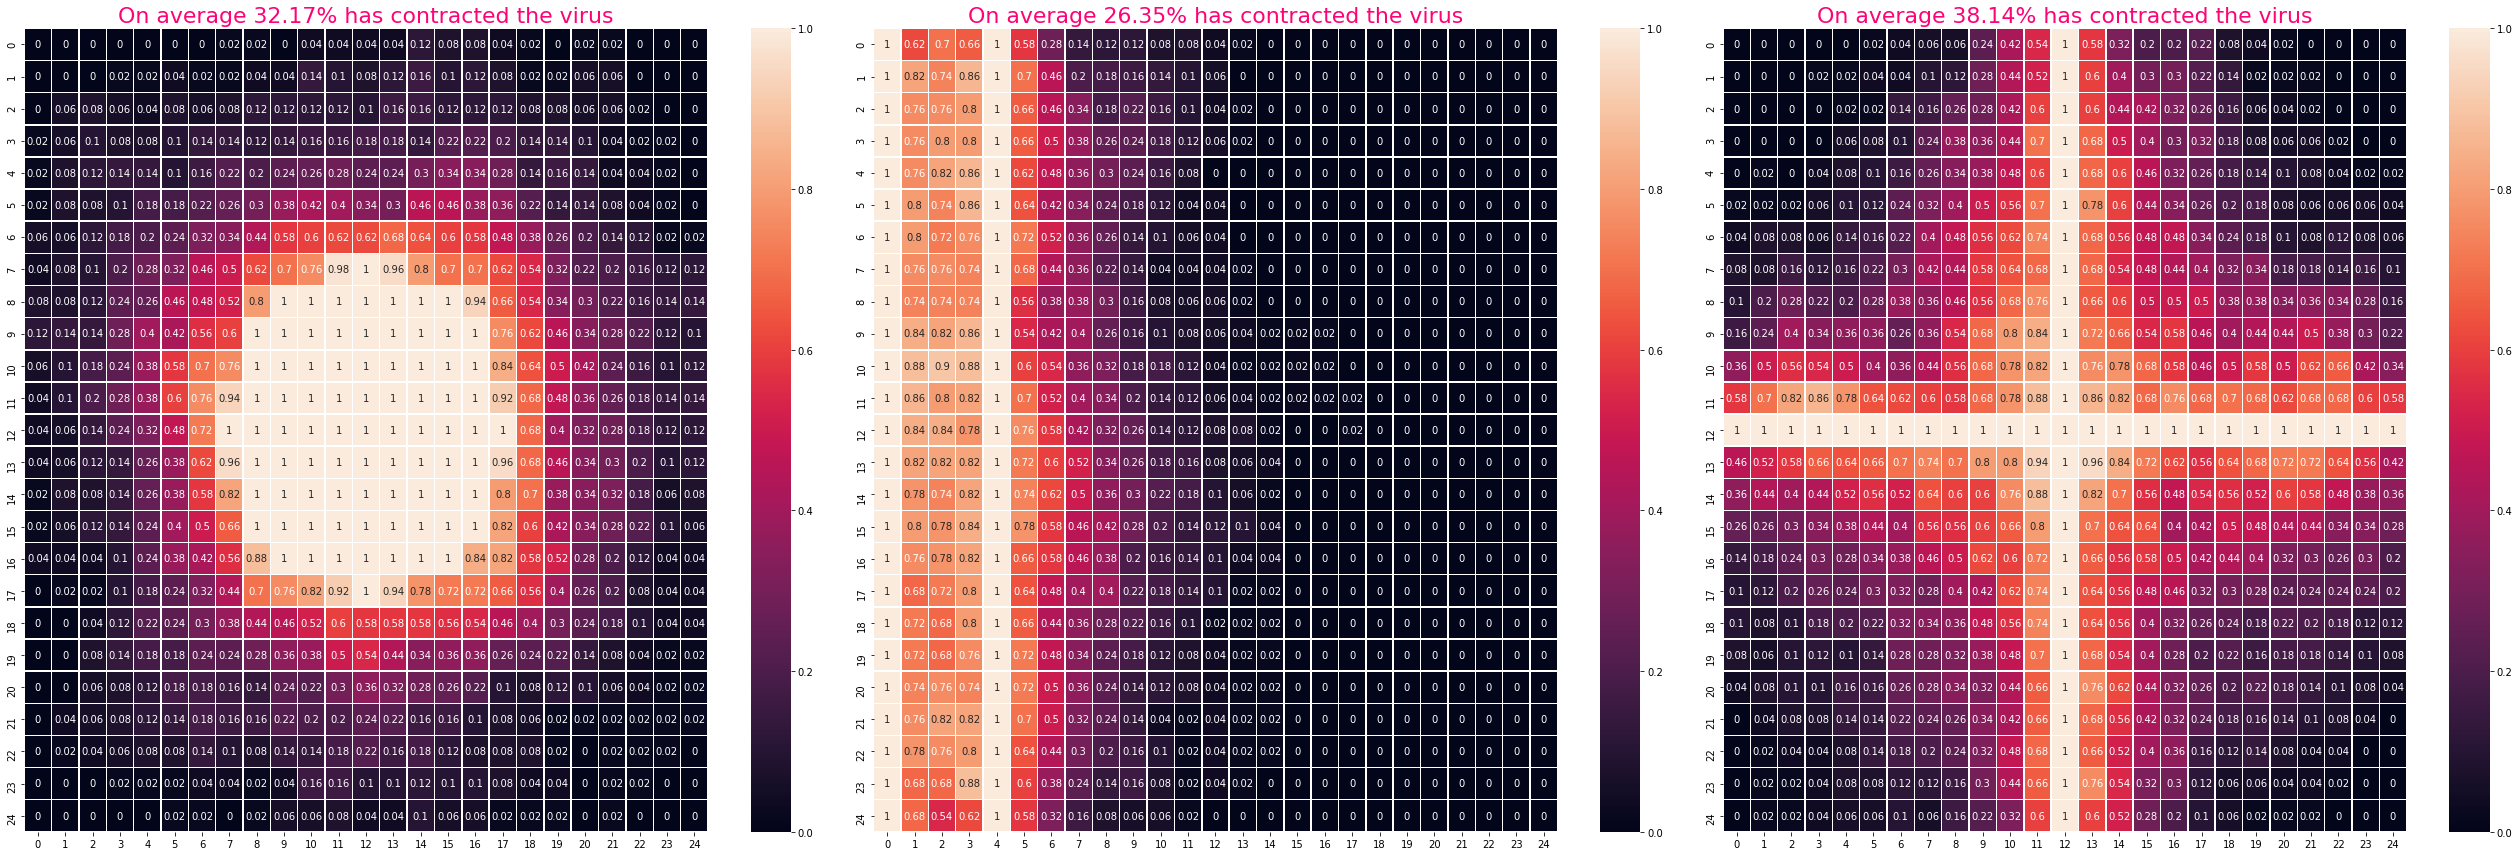

In [ ]:
per_infected_1 = (100*np.mean(n_infection_1))/(shape[0]*shape[1])
per_infected_2 = (100*np.mean(n_infection_2))/(shape[0]*shape[1])
per_infected_3 = (100*np.mean(n_infection_3))/(shape[0]*shape[1])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (36,12))
sns.heatmap(occ_matrix_1, linewidth=0.5, annot=True, ax=ax1)
sns.heatmap(occ_matrix_2, linewidth=0.5, annot=True, ax=ax2)
sns.heatmap(occ_matrix_3, linewidth=0.5, annot=True, ax=ax3)
ax1.set_title("On average {:.2f}% has contracted the virus".format(per_infected_1), fontsize=22, color='#fc0377')
ax2.set_title("On average {:.2f}% has contracted the virus".format(per_infected_2), fontsize=22, color='#fc0377')
ax3.set_title("On average {:.2f}% has contracted the virus".format(per_infected_3), fontsize=22, color='#fc0377')
plt.tight_layout()
plt.show()

# Hexagonal lattice

In [ ]:
shape = (20,20)
prova_grid = gridV1(shape, "hex", print_var = True)


epochs=30
ColorLegend = {"Recovered":"#7CFC00","Susceptible":"#0000FF","1-Day_Infected":"#FFA500",">1-day_Infected":"#FF4500"}
fig = plt.figure(figsize=(24,40))
ax = fig.add_subplot(1,1,1)
plt.axis('off')

for i in range(0,epochs):

  col_arr, layout_regular = prova_grid.getNodesEdges()

  for l in list(ColorLegend.keys()):
      ax.scatter([0],[0],color=ColorLegend[l],label=l)

  nodes = nx.draw_networkx_nodes(prova_grid.G, pos=layout_regular, node_color = col_arr, with_labels = False, ax=ax, node_shape='h', node_size= 16000)
  nodes.set_edgecolor('w')
  nodes.set_linewidth(4)
  #edges = nx.draw_networkx_edges(prova_grid.G, pos=layout_regular)
  ax.set_title("Grid at step: "+str(i), fontsize=50)
  legend_aspect=ax.legend(ColorLegend, loc='upper right', bbox_to_anchor=(1.5, 1.04), fontsize=35, framealpha=0.45)
  legend_aspect.legendHandles[0]._sizes=[650]
  legend_aspect.legendHandles[1]._sizes=[650]
  legend_aspect.legendHandles[2]._sizes=[650]
  legend_aspect.legendHandles[3]._sizes=[650]
  prova_grid.update()
  fig.savefig('hex_frame_' + str(i) + '.png', bbox_inches = 'tight')

ims=[]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
plt.axis('off')

for i in range(epochs):
  frame = mgimg.imread('hex_frame_' + str(i) + '.png')
  frameplot = ax.imshow(frame, animated=True)
  ims.append([frameplot, title]) 
  plt.close()


ani = animation.ArtistAnimation(fig, ims, blit=True, interval = 700 ,repeat_delay=1000)
fig.tight_layout()
ani.save("animation_hex.mp4")
HTML(ani.to_html5_video())




CREATION - START
    GRID CREATION - START
    GRID CREATION - END
    SET ATTRIBUTES - START
    SET ATTRIBUTES - END
CREATION - END


# Conclusions

In this project we tried different approaches to simulate the SIR model. The results obtained in some simulation are similar to the numerical solution for the differential equations, which is to be expected.
Even though the SIR model is one of the most used, there are several different model which are used in different scenarios.
For example the SIRS model where the immunity is not permanent and an individual could contract the virus more than once. Or the SICR model, where infected enter a chronic from which the (almost) never recover. 

Another important thing to notice from our results is that the initial spatial distribution of the infected really influence the final percentage of people who contracted the virus. A distribution of small and randomly placed outbreaks gives the "worst result" by far, while a single big outbreak is a lot more manageable. For example, in the estimation of the probability in the heatmaps 2 and 3, we can see that, even though we start from the same number of infected cells, we have a variation of ~12% between the final number of the infected people. 

In this project we treated only the SIR model. But this work is a good starting point for future projects on more advanced models (like SIRS, SICS, etc.).

